# Attribution Maps Workflow
This notebook demonstrates loading models, training them, printing model layers, and applying the Grad-CAM workflow.

In [1]:
# Enable autoreload for imports
%load_ext autoreload
%autoreload 2
# Import necessary modules
from models import PneumoniaCNN, PneumoniaResNet
from grad_cam import GradCAM
from train_cnn import train_net, eval_net
from dataloaders import train_loader, val_loader, test_loader
import cv2

import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn, optim

In [2]:
# Initialize models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cnn_model = PneumoniaCNN().to(device)
# resnet_model = PneumoniaResNet().to(device)

In [8]:
# Train models
# criterion = nn.CrossEntropyLoss()
# optimizer_cnn = optim.Adam(cnn_model.parameters(), lr=0.001)
# optimizer_resnet = optim.Adam(resnet_model.parameters(), lr=0.001)

# print("Training CNN Model...")
# train_net(cnn_model, train_loader, val_loader, criterion, optimizer_cnn, device, epochs=5)
# eval_net(cnn_model, test_loader, device)



# # print("Training ResNet Model...")
# # train_net(resnet_model, train_loader, val_loader, criterion, optimizer_resnet, device, epochs=5)
# # eval_net(resnet_model, test_loader, device)


# # save the model
# torch.save(cnn_model.state_dict(), 'model_state_dicts/cnn_model.pth')
# torch.save(resnet_model.state_dict(), 'model_state_dicts/resnet_model.pth')


# load the cnn_model state dict
cnn_model.load_state_dict(torch.load('cnn_model.pt'))


<All keys matched successfully>

In [9]:
# Print model layers
print("CNN Model Layers:")
print(cnn_model)

for name, layer in cnn_model.named_modules():
    print(f"Layer: {name}, Type: {type(layer)}")

# print("ResNet Model Layers:")
# print(resnet_model)

CNN Model Layers:
PneumoniaCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=200704, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)
Layer: , Type: <class 'models.PneumoniaCNN'>
Layer: conv1, Type: <class 'torch.nn.modules.conv.Conv2d'>
Layer: pool1, Type: <class 'torch.nn.modules.pooling.MaxPool2d'>
Layer: conv2, Type: <class 'torch.nn.modules.conv.Conv2d'>
Layer: pool2, Type: <class 'torch.nn.modules.pooling.MaxPool2d'>
Layer: fc1, Type: <class 'torch.nn.modules.linear.Linear'>
Layer: fc2, Type: <class 'torch.nn.modules.linear.Linear'>


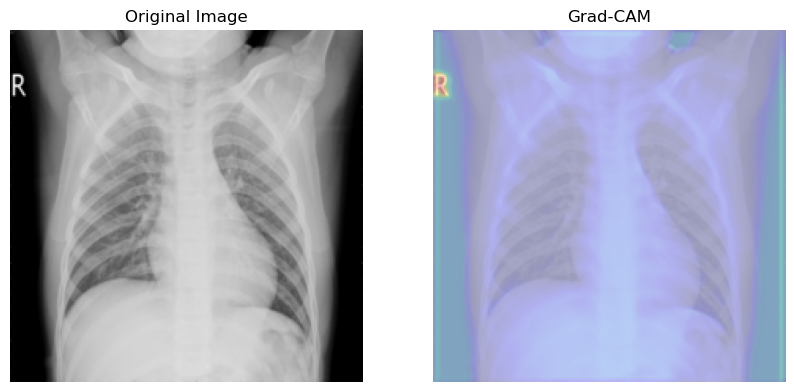

(224, 224, 3)


In [14]:
# Apply Grad-CAM workflow
target_layer = cnn_model.conv2
grad_cam = GradCAM(cnn_model, target_layer)

# write a function to get n sample outputs from label = "NORMAL" or pneumonia
def get_samples_by_label(loader, label, n=5):
    samples = []
    for images, labels in loader:
        for img, lbl in zip(images, labels):
            if lbl.item() == label:
                samples.append(img)
                if len(samples) == n:
                    return samples
    return samples

images_normal = get_samples_by_label(val_loader, 0, n=5)  # Get 5 samples with label "NORMAL"
images_pneumonia = get_samples_by_label(val_loader, 1, n=5)  # Get 5 samples with label "PNEUMONIA"
# Get a sample input
# data_iter = iter(val_loader)
# images, labels = next(data_iter)
# input_tensor = images[0].unsqueeze(0).to(device)

images = images_normal.copy()


input_tensor = images[0].unsqueeze(0).to(device)  # Use the first image from the list

# Generate CAM
cam = grad_cam.generate_cam(input_tensor)

# Visualize

image =  images[0].permute(1, 2, 0).numpy() # shift color channels to last dimension
image = (image * 0.5 + 0.5) * 255  # Denormalize
image = image.astype(np.uint8)
overlay = grad_cam.overlay_cam(image, cam)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(image, cmap="gray")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Grad-CAM")
plt.imshow(overlay, cmap="jet", alpha=0.5)
plt.axis("off")
plt.show()

print(overlay.shape)